# This notebook describe how to train 2D CNN model and explore different hyperparameters.

# How folders are organized:

<br> each model has unique name defined by the model type, the time it was produced and the job. 
<br> EG: CNN.CNNmodel_3.7.19_14.30_315175[1]  = model_type + date + time + job 
<br> Here model_type is CNN.CNNmodel


<br> **/deforestation_forecasting/models/model_type**
        
        Have the best epoch checkpoints of models produced by each job, named by the model unique name

<br>**/deforestation_forecasting/models/pics**
        
        Have images tracking BCELoss, Cost, AUC during training epoches and ROC curve on validation data for each model. 
        Each pictire is named as the model unique name + _AUC.png / _Cost.pmg / _BCEloss.png  _ROC.png 

<br>**/deforestation_forecasting/models/grid_summary/model_type.txt**
        
        Is a summary table of all models produced by parallel jobs

<br>**/deforestation_forecasting/models/txt_outputs/model_type**
        
        Have the logs of running each job (training reports). A log run of a job has name model_type.PBS_JOBID ,eg CNN.CNNmodel.315175[1] here [1] for job = 1

To get all this results you need to submit pbs file  **Hansen/deforestation_forecasting/python_code/qsub/model_type/model_type.pbs** 
        
        eg qsub CNN.CNNmodel.pbs; This will run the file model_type.py with 12 parallel jobs.

# Below is detailed explanation what model_type.py is. Here CNN.CNNmodel.py

In [1]:
%cd '/rdsgpfs/general/user/kpp15/home/Hansen/deforestation_forecasting/python_code'
import os
import torch
import numpy as np
import time
from CNN import *
from Training import *
from Data_maker_loader import *
server = '/rdsgpfs/general/user/kpp15/home/Hansen'
#from where to load tensors for data
wherepath = server + '/data/raster/tensors'
#Where to save model checkpoint
modelpath = server + "/deforestation_forecasting/models"
#Where to save images tracking training process
picspath = server + "/deforestation_forecasting/models/pics"
#Where to save results for models performance of each job on train test and val data set 
file = server + "/deforestation_forecasting/models/grid_summary/CNN.CNNmodel.txt"

/rdsgpfs/general/user/kpp15/home/Hansen/deforestation_forecasting/python_code


## Set main hyper parameters

In [2]:
# start = time.time()
# Set all parameters 

#Set training time period 
start_year = 14
end_year = 16

#set CNN model parameeters
size = 45
input_dim=11 
hidden_dim=[128,64,64,32]
kernel_size = [(5,5),(5,5),(3,3),(3,3)]
stride = [(2,2),(1,1),(1,1),(1,1)]
padding =[0,0,0,0]
dropout = 0.2
levels=[13]

#set ratios of 0:1 labels in Train and Validation data sets
train_times = 4
test_times = 4

#set criteria for Early stopping
AUC = False
BCE_Wloss = False
FNcond = True 
# set parameters for the cost of the confussion matrix
w = 10 # weights on the False Negative Rate
perc = (100*train_times) / (train_times+1) # the percentile to for treshhold selection. Advisable to be 100*times/(times+1)

# Weight parameter for the weighted BCE loss
pos_weight = 5

#Adam optimiser parameters:
lr = 0.0001 
weight_decay = 0  

#Early Stopping parameters 
batch_size = 80
n_splits = 5
n_epochs = 5
patience = 3

#train_model parameters for debbuging and time regulations  
training_time = 5
stop_batch = 4
print_batch = 2
batch_size = 10

In [10]:
# To explote different parameters in parallel 
# job = int(os.environ['PBS_ARRAY_INDEX'])
# job_id  = str(os.environ['PBS_JOBID'])

job = 1
job_id = "315175[1]"
if job == 2:
    hidden_dim=[32,32,64,64]
    kernel_size = [(7,7),(7,7),(5,5),(5,5)]
    stride = [(2,2),(1,1),(1,1),(1,1)]
    levels = [6]

if job == 3:   
    hidden_dim=[64,64,64,64]
    kernel_size = [(7,7),(7,7),(5,5),(5,5)]
    stride = [(2,2),(1,1),(1,1),(1,1)]
    levels = [6]

if job == 4:
    hidden_dim=[64,64,64,64]
    kernel_size = [(7,7),(7,7),(5,5),(5,5)]
    stride = [(2,2),(1,1),(1,1),(1,1)]
    levels = [6]

if job == 5:
    hidden_dim=[64,128,128,64]
    kernel_size = [(7,7),(7,7),(5,5),(5,5)]
    stride = [(2,2),(1,1),(1,1),(1,1)]
    levels = [6]

if job == 6:
    hidden_dim=[64,64,64,64]
    kernel_size = [(5,5),(5,5),(5,5),(5,5)]
    stride = [(2,2),(1,1),(1,1),(1,1)]
    levels = [9]

if job == 7:
    hidden_dim=[64,128,128,64]
    kernel_size = [(5,5),(5,5),(5,5),(5,5)]
    stride = [(2,2),(1,1),(1,1),(1,1)]
    levels = [9]
    
if job == 8:
    hidden_dim=[64,64,64,32]
    kernel_size = [(5,5),(5,5),(3,3),(3,3)]
    stride = [(2,2),(1,1),(1,1),(1,1)]
    levels=[6,2]

if job == 9:
    weight_decay = 0.5

if job == 10:
    pos_weight = 1 

if job == 11:
    pos_weight = 2

if job == 12:
    lr = 0.001 

# Set model, loss and optimiser

In [4]:
model = CNNmodel(
            input_dim = input_dim,
            hidden_dim = hidden_dim,
            kernel_size = kernel_size,
            stride = stride,
            padding = padding,
            dropout = dropout,
            levels = levels)
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean', pos_weight = torch.tensor(3))
optimiser = torch.optim.Adam(params=model.parameters(), lr=0.0001, weight_decay=0.)

# Load data

In [5]:
def with_DSM(size, start_year, end_year, wherepath, DSM = False):
"""
Regulate later if new layers are added in add_static or add_time
"""   
    if DSM:
        DSM = torch.load(wherepath+"/DSM.pt")
        Data = load_CNNdata(size = size, start_year = start_year, end_year = end_year, path = wherepath, add_static = [DSM])
    else:
        Data = load_CNNdata(size = size, start_year = start_year, end_year = end_year, path = wherepath, add_static = None)
    
    return Data
        
Data =  with_DSM(size = int(size/2), start_year = start_year, end_year = end_year, wherepath = wherepath , DSM = True)

## Split to train and val datasets

In [6]:
if not (os.path.isfile(wherepath+"/"+"Train_idx%d.npy"%(end_year)) & os.path.isfile(wherepath+"/"+"Test_idx%d.npy"%(end_year))):
    print("Creating indexes split")
    train_idx, test_idx = train_test_split(np.arange(len(Data.labels)),
                                            test_size=0.2, random_state=42, shuffle=True, stratify=Data.labels)
    np.save(wherepath+"Train_idx%d.npy"%(end_year),train_idx)
    np.save(wherepath+"Test_idx%d.npy"%(end_year),test_idx)
else:
    train_idx = np.load(wherepath+"/"+"Train_idx%d.npy"%(end_year))
    test_idx = np.load(wherepath+"/"+"Test_idx%d.npy"%(end_year)) 

## Undersample 

In [7]:
train_sampler = ImbalancedDatasetUnderSampler(labels = Data.labels, indices=train_idx, times = train_times)
test_sampler = ImbalancedDatasetUnderSampler(labels = Data.labels, indices=test_idx, times = test_times)

# Print info before training

In [12]:
#Print Summary of the training parameters
# =========================================================================    
print("Model:",str(type(model))[8:-2],"\nPeriod 20%d-20%d -> 20%d"%(start_year,end_year,end_year+1))
print("\t% deforested pixels in train:",train_sampler.count[1]/sum(train_sampler.count))
print("\t% deforested pixels in val:",test_sampler.count[1]/sum(test_sampler.count))
print("Job: ",job_id)   
print("\nHyperparameters: ")
print("\tImage size: %d"%(size))
print("\tHidden dim: ",hidden_dim)
print("\tTrain and Val ratios of 0:1 labels: 1:%d ; 1:%d "%(train_times, test_times))
print("\tADAM optimizer parameters: lr=%.7f, weight decay=%.2f, batch size=%d"%(lr,weight_decay,batch_size))
print("\tBCEWithLogitsLoss pos_weights = %.2f"%(pos_weight))
print("\tn_epochs = %d with patience of %d epochs"%(n_epochs,patience))
print("\tCross Validation with n_splits = %d "%(n_splits))
print("\tIf to use BCEWithLogitsLoss as an early stop criterion :",((not AUC)&(not FNcond)))
print("\tIf to use AUC as an early stop criterion :",AUC)
print("\tIf to use cost = FP+w*FN / TP+FP+w*FN+TN as an early stop criterion")
print("\twith w = %d and treshhold = the %d percentile of the output"%(w,perc),FNcond)
print("\nModel: \n",model)
print("\nCriterion: \n",criterion)
print("\nOptimiser: \n",optimiser)

Model: CNN.CNNmodel 
Period 2014-2016 -> 2017
	% deforested pixels in train: 0.001670405432848712
	% deforested pixels in val: 0.0016809372732169796
Job:  315175[1]

Hyperparameters: 
	Image size: 45
	Hidden dim:  [128, 64, 64, 32]
	Train and Val ratios of 0:1 labels: 1:4 ; 1:4 
	ADAM optimizer parameters: lr=0.0001000, weight decay=0.00, batch size=10
	BCEWithLogitsLoss pos_weights = 5.00
	n_epochs = 5 with patience of 3 epochs
	Cross Validation with n_splits = 5 
	If to use BCEWithLogitsLoss as an early stop criterion : False
	If to use AUC as an early stop criterion : False
	If to use cost = FP+w*FN / TP+FP+w*FN+TN as an early stop criterion
	with w = 10 and treshhold = the 80 percentile of the output True

Model: 
 CNNmodel(
  (conv): Sequential(
    (0): Conv2d(11, 128, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU

# Start Training

### Model saved at /Hansen/deforestation_forecasting/models/CNN.CNNmodel/

In [11]:
model, train_loss, valid_loss, AUCs_train, AUCs_val ,costs_train, costs_val, name = train_model(Data = Data,
            model = model,
            sampler = train_sampler,
            criterion = criterion,
            optimiser = optimiser,
            patience = patience,
            n_epochs = n_epochs,
            n_splits = n_splits,                                                                                    
            batch_size = batch_size,
            stop_batch = stop_batch,
            print_batch = print_batch,
            training_time = training_time,
            w = w,
            perc = perc,
            FNcond = FNcond,
            AUC = AUC,
            job = job_id,
            path = modelpath)


Date: 2019-07-03 16:53:10.447074

Checkpoint saved at: /rdsgpfs/general/user/kpp15/home/Hansen/deforestation_forecasting/models/CNN.CNNmodel/CNN.CNNmodel_3.7.19_16.53_315175[1].pt


Epoch 1, Fold 1 Train size 577320; Val size 144330

	Learning:...
	Epoch: 1 	Batch: 2 	Training Loss: 0.9445154070854187
	Stop learning

	Time to load 4 train batches of size 10 : 0.0051 hours 

	AUC and CM on Train data
	AUC : 0.6536796536796536
	Pred:   	 0 		 1
	True: 0 	 27 		 6
	True: 1 	 5 		 2
	True Positive Rate  0.2857142857142857
	Cost = FP+w*FN/TP+FP+w*FN+TN = 0.6588 (w = 10)
	Treshold 0.5721 when percentage of 0 predicted labels is 80

	Time to load 4 val batches of size 10 : 0.0015 hours 
	AUC and CM on Val data
	AUC : 0.8633333333333333
	Pred:   	 0 		 1
	True: 0 	 29 		 1
	True: 1 	 3 		 7
	True Positive Rate  0.7
	Cost = FP+w*FN/TP+FP+w*FN+TN = 0.4627 (w = 10)
	Treshold 0.4768 when percentage of 0 predicted labels is 80


Epoch summary: 
[1/5] train_loss: 0.89968 valid_loss: 1.04032
[1/5]  

# Visualize the training process and how AUC, Cost and Loss channged in each epoch on Train and Val data

### These pictures are present in Hansen/deforestation_forecasting/models/pics


Reporting BCEloss when training


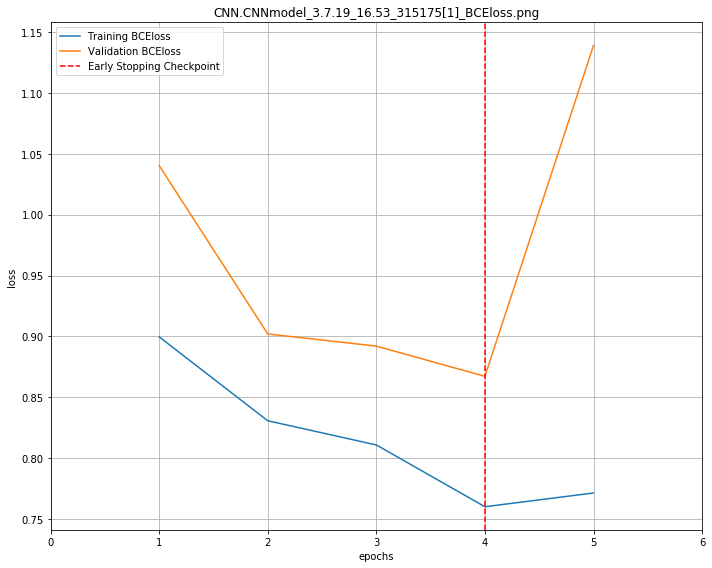

Figure saved at: /rdsgpfs/general/user/kpp15/home/Hansen/deforestation_forecasting/models/pics/CNN.CNNmodel_3.7.19_16.53_315175[1]_BCEloss.png

Reporting AUC when training


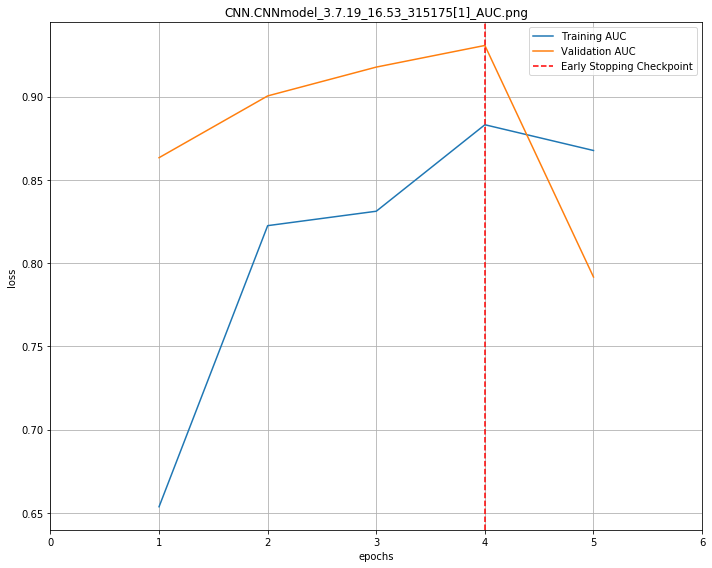

Figure saved at: /rdsgpfs/general/user/kpp15/home/Hansen/deforestation_forecasting/models/pics/CNN.CNNmodel_3.7.19_16.53_315175[1]_AUC.png

Reporting Cost when training


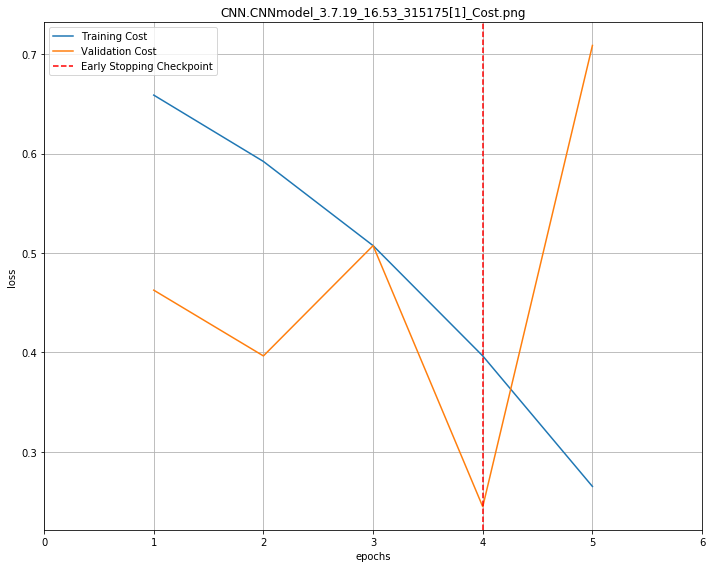

Figure saved at: /rdsgpfs/general/user/kpp15/home/Hansen/deforestation_forecasting/models/pics/CNN.CNNmodel_3.7.19_16.53_315175[1]_Cost.png


In [13]:
visualize(train = train_loss, valid = valid_loss, name = "BCEloss",
          modelname = name, best = "min", path = picspath)
visualize(train = AUCs_train, valid = AUCs_val, name = "AUC",
          modelname = name, best = "max", path = picspath)
visualize(train = costs_train, valid = costs_val, name = "Cost",
          modelname = name, best = "min", path = picspath)

# Test model on the validation data set

	Test Loss:  0.9738962769508361
	AUC : 0.9696969696969697
	Pred:   	 0 		 1
	True: 0 	 38 		 1
	True: 1 	 2 		 9
	True Positive Rate  0.8181818181818182
	Cost = FP+w*FN/TP+FP+w*FN+TN = 0.3088 (w = 10)
	Treshold 0.3930 when percentage of 0 predicted labels is 80


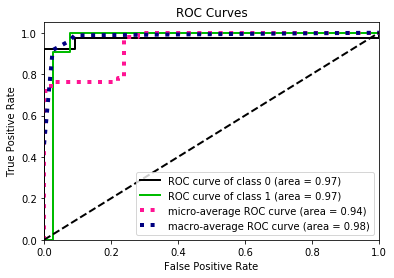

In [17]:
test_loss, test_AUC, test_cost = test_model(
    model = model,
    Data = Data,
    criterion = criterion,
    w = w,
    perc = perc,
    test_sampler = test_sampler,
    batch_size = batch_size,
    stop_batch = stop_batch,
    name = name,
    path = picspath)

### This is input in: Hansen/deforestation_forecasting/models/grid_summary/CNN.CNNmodel.txt

In [20]:
write_report(name = name,
             job_id = job_id,
             train_loss = train_loss,
             valid_loss = valid_loss,
             test_loss = test_loss,
             AUCs_train = AUCs_train,
             AUCs_val = AUCs_val,
             test_AUC = test_AUC,
             costs_train = costs_train,
             costs_val = costs_val,
             test_cost = test_cost,
             file = file,
             FNcond = FNcond, 
             AUC = AUC)

| Job:315175[1] | Model:CNN.CNNmodel_3.7.19_16.53_315175[1] | Best epoch:4 |
| Train loss:0.760 | Train AUC:0.883 | Train cost:0.397 |
|   Val loss:0.867 |   Val AUC:0.931 |   Val cost:0.245 |
|  Test loss:0.974 |  Test AUC:0.970 |  Test cost:0.309 |


## All above outputs are written in a report : Hansen/deforestation_forecasting/models/txt_outputs/CNN.CNNmodel/CNN.CNNmodel.315175[1]